In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils
import torch.autograd as autograd

cuda = False
# cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

**Hyperparameters**

In [29]:
# Please use the model trained w/o BN (batch normalization), otherwise we will have bug in inference...
# _tanh.pth: nn.Tanh() as activation
# other.pth: LeakyReLU as activation
class Para():
    def __init__(self):
        self.latent_dim = 2 # latent space dimention
        self.img_shape = (1, 28, 28) # image shape (1x28x28 for MNIST)
        self.generator_path = 'G_l2_woBN.pth' # pre-trained generator path
        self.discriminator_path = 'D_l2_woBN.pth' # pre-trained discriminator path
        self.batch_size = 25 # batch size for visualization
        self.gd_size = 21
        
opt = Para()

**Network architectures**

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            # layers.append(nn.Tanh())
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

    
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

**Load networks**

In [31]:
generator.load_state_dict(torch.load(opt.generator_path))
discriminator.load_state_dict(torch.load(opt.discriminator_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

**Generator and discriminator visualization**

In [32]:
def vis(y, nrow, title='figure', figsize=(4, 4)):
    imgs = torchvision.utils.make_grid(y, nrow=nrow, padding=0, normalize=True)

    plt.figure(figsize=figsize)
    if cuda:
        plt.imshow(imgs.permute(1, 2, 0).cpu())
    else:
        plt.imshow(imgs.permute(1, 2, 0))
    plt.title(title)
    plt.show()   

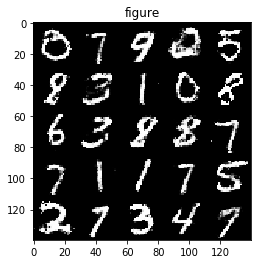

In [33]:
# z = Variable(torch.from_numpy(np.float32(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))) # latend variables
z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))

with torch.no_grad():
    generated_imgs = generator(z) # generate images
    validity = discriminator(generated_imgs) # discriminator validaty

vis(generated_imgs, nrow=int(np.sqrt(opt.batch_size)))

**EKI for the noise model $y=G(u)+\eta$**

We have prior $u\sim\mathcal(m,I)$ and noise model $\eta\sim\mathcal(0,a\cdot I)$.

(100, 2)
(100, 1, 28, 28)


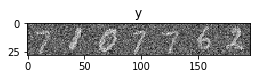

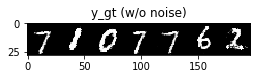

In [34]:
opt.gd_size = 100
k = np.prod(opt.img_shape)
d = opt.latent_dim
N = opt.gd_size
J = 20
u_gt = np.random.normal(0, 1, (N, d)) # ground truth u
a = 0.5
Gamma = a * np.eye(k)
eta = np.random.normal(0, np.sqrt(a), (N, *opt.img_shape)) # noise (we need sqrt)
with torch.no_grad():
    y_gt = generator(Tensor(u_gt)).numpy() # generated y from u_gt
    y = generator(Tensor(u_gt)).numpy() + eta # generated y from u_gt
    Y = y.reshape(N, k)
    
# Visualization of u_gt and y
print(u_gt.shape)
print(y.shape)
vis(Tensor(y[:7, :, :, :]), nrow=7, title='y')
vis(Tensor(y_gt[:7, :, :, :]), nrow=7, title='y_gt (w/o noise)')

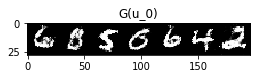

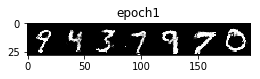

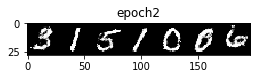

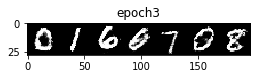

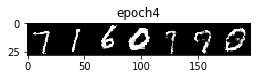

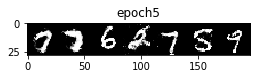

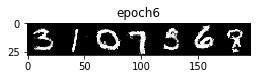

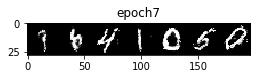

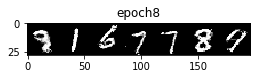

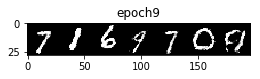

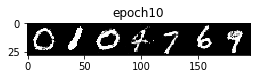

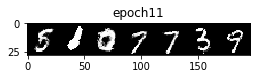

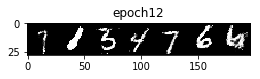

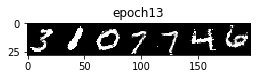

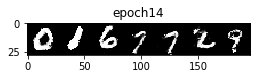

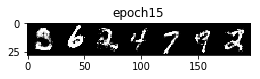

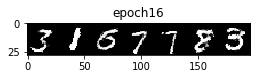

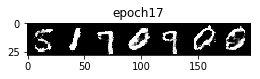

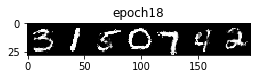

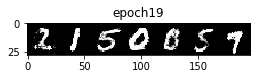

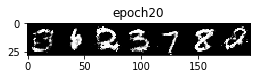

In [35]:
u_0 = np.random.normal(0, 1, (opt.gd_size, opt.latent_dim))
U = np.zeros((J+1, N, opt.latent_dim))
U[0, :, :] = u_0
u = u_0
with torch.no_grad():
    vis(generator(Tensor(u))[:7, :, :, :], nrow=7, title='G(u_0)')

for j in range(J):
    with torch.no_grad():
        u_bar = np.mean(u, 0).reshape(d, 1)
        G = generator(Tensor(u)).numpy().reshape(N, k)
        G_bar = np.mean(G, 0).reshape(k, 1)
        u_stack = u.transpose() - u_bar @ np.ones((1, N))
        G_stack = G - np.ones((N, 1)) @ G_bar.transpose()
        C_uw = 1/N * u_stack @ G_stack
        C_ww = 1/N * G_stack.transpose() @ G_stack
        u_tran = u.transpose() + C_uw @ np.linalg.inv(C_ww + Gamma) @ (Y - G).transpose()
        u = u_tran.transpose()
        
        U[j+1, :, :] = u
        vis(generator(Tensor(u))[:7, :, :, :], nrow=7, title=('epoch'+str(j+1)))

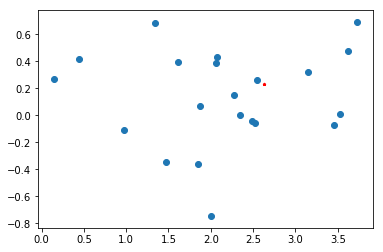

In [45]:
index = 1
plt.scatter(U[:, index, 0], U[:, index, 1])
plt.plot([u_gt[index, 0]], [u_gt[index, 1]], marker='*', markersize=3, color="red")
plt.show()

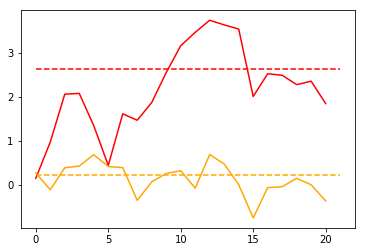

In [46]:
index = 1
cmap = plt.cm.get_cmap('hsv', 10)
for i in range(2):
    plt.plot(U[:, index, i], color=cmap(i))
    plt.hlines(y=u_gt[index, i], color=cmap(i), linestyles='--', xmin=0, xmax=len(U))
plt.show()